In [1]:
import os
import sys
import errno
import re
import glob
import os.path as op
import json
from datetime import datetime, timedelta
from IPython.display import display, clear_output, HTML
import numpy as np
from pathlib import Path
import pandas as pd
from osgeo import osr, ogr, gdal
from osgeo.gdalnumeric import *
from osgeo.gdalconst import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.gridspec as pltg
import seaborn as sn
from matplotlib.colors import LogNorm
import calendar
from pyproj import Proj, transform
import xml.etree.ElementTree as ET
import zipfile
import warnings
import random
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
def getDateFromStr(N):
    sepList = ["","-","_","/"]
    date = ''
    for s in sepList :
        found = re.search('\d{4}'+ s +'\d{2}'+ s +'\d{2}', N)
        if found != None :
           date = datetime.strptime(found.group(0), '%Y'+ s +'%m'+ s +'%d').date()
           break
    return date

def getTimeFromStr(N,):
    sepList = ["","-","_"]
    HHMMSS = ''
    for s in sepList :
        found = re.search('-'+'\d{2}'+ s +'\d{2}'+ s +'\d{2}'+'-'+'\d{3}'+'_', N)
        if found != None :
            HHMMSS = datetime.strptime(found.group(0), '-'+'%H'+ s +'%M'+ s +'%S'+"-"+'%f'+'_')
            break
    return HHMMSS

def reproject(inEPSG,outEPSG,x1,y1):
    
    inProj = Proj(init='EPSG:' + inEPSG)
    outProj = Proj(init='EPSG:'+ outEPSG)
    x2,y2 = transform(inProj,outProj,x1,y1)
    
    return x2, y2

def getOverlapCoords(G1,G2):
    
    epsg1 = (osr.SpatialReference(wkt=G1.GetProjection())).GetAttrValue('AUTHORITY',1)
    epsg2 = (osr.SpatialReference(wkt=G2.GetProjection())).GetAttrValue('AUTHORITY',1)
    GT1 = G1.GetGeoTransform()
    minx1 = GT1[0]
    maxy1 = GT1[3]
    maxx1 = minx1 + GT1[1] * G1.RasterXSize
    miny1 = maxy1 + GT1[5] * G1.RasterYSize
    
    GT2 = G2.GetGeoTransform()
    minx2 = GT2[0]
    maxy2 = GT2[3]
    maxx2 = minx2 + GT2[1] * G2.RasterXSize
    miny2 = maxy2 + GT2[5] * G2.RasterYSize
    
    if epsg1 not in epsg2 :
        minx1 , miny1 = reproject(epsg1,epsg2,minx1,miny1)
        maxx1 , maxy1 = reproject(epsg1,epsg2,maxx1,maxy1)
    
    
    minx3 = max(minx1,minx2)
    maxy3 = min(maxy1,maxy2)
    maxx3 = min(maxx1,maxx2)
    miny3 = max(miny1,miny2)   
    
    # no intersection 
    if (minx3 > maxx3 or miny3 > maxy3) : 
        return None,None,None,None
    
    return minx3, maxy3, maxx3, miny3  #projection de G2

def getCoords(G):
    
    
    GT = G.GetGeoTransform()
    minx = GT[0]
    maxy = GT[3]
    maxx = minx + GT[1] * G.RasterXSize
    miny = maxy + GT[5] * G.RasterYSize
    
    return minx, maxy, maxx, miny

def mkdir_p(dos):
    try:
        os.makedirs(dos)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(dos):
            pass
        else:
            raise
            
def getTileFromStr(N):

    tile = ''
    found = re.search('\d{2}' +'[A-Z]{3}', N)
    if found != None : tile = found.group(0)
    return tile

def getSPOTGRSFromStr(N):
    K = ''
    J = ''
    found = re.search('_'+'\d{3}'+'-' +'\d{3}'+'-'+'\d{1}', N)
    if found != None : 
        GRS = found.group(0)
        GRS_s = GRS.split('-')
        K = int(GRS_s[0][1:])
        J = int(GRS_s[1])
        S = int(GRS_s[2])
    
    return K,J,S
def divide_chunks(l, n): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 
def getmetrics(cm11,cm12,cm13,cm21,cm22,cm23,cm31,cm32,cm33):
    #calculation of class 1 metrics
    TP_1 = cm11
    TN_1 = cm22 + cm33 + cm23 + cm32
    FP_1 = cm21 + cm31
    FN_1 = cm12 + cm13
    Precision_1 = TP_1/(TP_1 + FP_1)
    Recall_1 = TP_1/(TP_1+FN_1)
    F1_1 = 2*Precision_1*Recall_1/(Precision_1+Recall_1)

    
    #calculation of class 2 metrics
    TP_2 = cm22
    TN_2 = cm11 + cm33 + cm13 + cm31
    FP_2 = cm12 + cm32
    FN_2 = cm21 + cm23
    Precision_2 = TP_2/(TP_2 + FP_2)
    Recall_2= TP_2/(TP_2+FN_2)
    F1_2= 2*Precision_2*Recall_2/(Precision_2+Recall_2)

    
    #calculation of class 3 metrics
    TP_3 = cm33
    TN_3 = cm11 + cm22 + cm12 + cm21
    FP_3 = cm13 + cm23
    FN_3 = cm31 + cm32
    Precision_3= TP_3/(TP_3 + FP_3)
    Recall_3= TP_3/(TP_3+FN_3)
    F1_3= 2*Precision_3*Recall_3/(Precision_3+Recall_3)
    

    #calculation of multiclass metrics
    total = cm11+cm12+cm13+cm21+cm22+cm23+cm31+cm32+cm33
    Agree = (cm11+cm22+cm33)/total
    ChanceAgree1 =(cm11+cm12+cm13)/total * (cm11+cm21+cm31)/total
    ChanceAgree2 =(cm21+cm22+cm23)/total * (cm12+cm22+cm32)/total
    ChanceAgree3 =(cm31+cm32+cm33)/total * (cm13+cm23+cm33)/total
    ChanceAgree = ChanceAgree1 + ChanceAgree2 + ChanceAgree3 
    kappa = (Agree - ChanceAgree)/(1 - ChanceAgree)
    micro_precision = (TP_1+TP_2+TP_3)/(TP_1+TP_2+TP_3+FP_1+FP_2+FP_3)
    micro_recall = (TP_1+TP_2+TP_3)/(TP_1+TP_2+TP_3+FN_1+FN_2+FN_3)
    micro_F1 = 2*micro_precision*micro_recall/(micro_precision+micro_recall)
    macro_precision = (Precision_1+Precision_2+Precision_3)/3.0
    macro_recall = (Recall_1+Recall_2+Recall_3)/3.0
    macro_F1 = (F1_1+F1_2+F1_3)/3.0
    OA = Agree
    WOA = (Recall_1 + Recall_2 + Recall_3) / 3
    
    return kappa, OA, WOA, [F1_1, F1_2, F1_3], [Recall_1, Recall_2, Recall_3], [Precision_1, Precision_2, Precision_3]

In [3]:
S2_tiles={
    "PYR":
    {
        "30TXN":{'EPSG':'32630','MINX':600000,'MINY':4690200,'MAXX':709800,'MAXY':4800000},
        '30TYN':{'EPSG':'32630','MINX':699960,'MINY':4690200,'MAXX':809760,'MAXY':4800000},
        '31TCH':{'EPSG':'32631','MINX':300000,'MINY':4690200,'MAXX':409800,'MAXY':4800000},
        '31TDH':{'EPSG':'32631','MINX':399960,'MINY':4690200,'MAXX':509760,'MAXY':4800000}
    },
    "ALP":
    {
        "31TGJ":{'EPSG':'32631','MINX':699960,'MINY':4790220,'MAXX':809760,'MAXY':4900020},
        '31TGK':{'EPSG':'32631','MINX':699960,'MINY':4890240,'MAXX':809760,'MAXY':5000040},
        '31TGL':{'EPSG':'32631','MINX':699960,'MINY':4990200,'MAXX':809760,'MAXY':5100000},
        '31TGM':{'EPSG':'32631','MINX':699960,'MINY':5090220,'MAXX':809760,'MAXY':5200020},
        "32TLP":{'EPSG':'32632','MINX':300000,'MINY':4790220,'MAXX':409800,'MAXY':4900020},
        '32TLQ':{'EPSG':'32632','MINX':300000,'MINY':4890240,'MAXX':409800,'MAXY':5000040},
        '32TLR':{'EPSG':'32632','MINX':300000,'MINY':4990200,'MAXX':409800,'MAXY':5100000},
        '32TLS':{'EPSG':'32632','MINX':300000,'MINY':5090220,'MAXX':409800,'MAXY':5200020}
    }
}





S2_4326_tiles={
    "PYR":
    {
        "30TXN":{'EPSG':'32630','MINX':reproject('32630','4326',600000,4690200)[0],'MINY':reproject('32630','4326',600000,4690200)[1],'MAXX':reproject('32630','4326',709800,4800000)[0],'MAXY':reproject('32630','4326',709800,4800000)[1]
                },
        '30TYN':{'EPSG':'32630','MINX':reproject('32630','4326',699960,4690200)[0],'MINY':reproject('32630','4326',699960,4690200)[1],'MAXX':reproject('32630','4326',809760,4800000)[0],'MAXY':reproject('32630','4326',809760,4800000)[1]
                },
        '31TCH':{'EPSG':'32631','MINX':reproject('32631','4326',300000,4690200)[0],'MINY':reproject('32631','4326',300000,4690200)[1],'MAXX':reproject('32631','4326',409800,4800000)[0],'MAXY':reproject('32631','4326',409800,4800000)[1]
                },
        '31TDH':{'EPSG':'32631','MINX':reproject('32631','4326',399960,4690200)[0],'MINY':reproject('32631','4326',399960,4690200)[1],'MAXX':reproject('32631','4326',509760,4800000)[0],'MAXY':reproject('32631','4326',509760,4800000)[1]
                }
    },
    "ALP":
    {
        "31TGJ":{'EPSG':'32631','MINX':reproject('32631','4326',699960,4790220)[0],'MINY':reproject('32631','4326',699960,4790220)[1],'MAXX':reproject('32631','4326',809760,4900020)[0],'MAXY':reproject('32631','4326',809760,4900020)[1]
                },
        '31TGK':{'EPSG':'32631','MINX':reproject('32631','4326',699960,4890240)[0],'MINY':reproject('32631','4326',699960,4890240)[1],'MAXX':reproject('32631','4326',809760,5000040)[0],'MAXY':reproject('32631','4326',809760,5000040)[1]
                },
        '31TGL':{'EPSG':'32631','MINX':reproject('32631','4326',699960,4990200)[0],'MINY':reproject('32631','4326',699960,4990200)[1],'MAXX':reproject('32631','4326',809760,5100000)[0],'MAXY':reproject('32631','4326',809760,5100000)[1]
                },
        '31TGM':{'EPSG':'32631','MINX':reproject('32631','4326',699960,5090220)[0],'MINY':reproject('32631','4326',699960,5090220)[1],'MAXX':reproject('32631','4326',809760,5200020)[0],'MAXY':reproject('32631','4326',809760,5200020)[1]
                },
        "32TLP":{'EPSG':'32632','MINX':reproject('32632','4326',300000,4790220)[0],'MINY':reproject('32632','4326',300000,4790220)[1],'MAXX':reproject('32632','4326',409800,4900020)[0],'MAXY':reproject('32632','4326',409800,4900020)[1]
                },
        '32TLQ':{'EPSG':'32632','MINX':reproject('32632','4326',300000,4890240)[0],'MINY':reproject('32632','4326',300000,4890240)[1],'MAXX':reproject('32632','4326',409800,5000040)[0],'MAXY':reproject('32632','4326',409800,5000040)[1]
                },
        '32TLR':{'EPSG':'32632','MINX':reproject('32632','4326',300000,4990200)[0],'MINY':reproject('32632','4326',300000,4990200)[1],'MAXX':reproject('32632','4326',409800,5100000)[0],'MAXY':reproject('32632','4326',409800,5100000)[1]
                },
        '32TLS':{'EPSG':'32632','MINX':reproject('32632','4326',300000,5090220)[0],'MINY':reproject('32632','4326',300000,5090220)[1],'MAXX':reproject('32632','4326',409800,5200020)[0],'MAXY':reproject('32632','4326',409800,5200020)[1]
                }
    }
}



LANDSAT_wrs_tiles={
    "ALP":
    {
        "195029":["31TGJ",'31TGK','31TGL',"32TLP",'32TLQ','32TLR'],
        "195028":['31TGL','31TGM','32TLQ','32TLR','32TLS'],
        "196029":["31TGJ",'31TGK','31TGL','32TLQ','32TLR'],
        "196028":['31TGK','31TGL','31TGM','32TLQ','32TLR','32TLS'],
        "194029":["32TLP",'32TLQ','32TLR']
    },
    "PYR":
    {
        "200030":["30TXN",'30TYN'],
        "199030":["30TXN",'30TYN','31TCH'],
        "198031":['31TCH','31TDH'],
        "198030":['31TCH','31TDH'],
        "197031":['31TDH']
    }
}

LANDSAT_tiles_wrs={
    "ALP":
    {
        "31TGJ":["195029","196029"],
        '31TGK':["195029","196029","196028"],
        '31TGL':["195029","195028","196029","196028"],
        '31TGM':["195028","196028"],
        "32TLP":["194029","195029"],
        '32TLQ':["194029","195029","195028","196029","196028"],
        '32TLR':["194029","195029","195028","196029","196028"],
        '32TLS':["195028","196028"]
    },
    "PYR":
    {
        "30TXN":["199030","200030"],
        "30TYN":["199030","200030"],
        "31TCH":["198030","198031","199030"],
        "31TDH":["197031","198030","198031"]
    }
}

SPOT_tile={
    "ALP":
    {"KMIN":46,
     "KMAX":55,
     "JMIN":254,
     "JMAX":263
    },
    "PYR":
    {"KMIN":35,
     "KMAX":48,
     "JMIN":262,
     "JMAX":265
    }
}

In [4]:

TCD_PATH="/work/datalake/static_aux/TreeCoverDensity"
DEM_PATH="/work/CAMPUS/etudes/Neige/DEM"
dict_swh_path = "/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/TIMESERIES_PROJECT/SWH_THEIA/dict_pyr_alps_SWH_THEIA.json"
swh_path = "muscate/SPOTWORLDHERITAGE"

list_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/inference_code/list_large"
test_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/inference_code/test"
inference_path ="/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/inference_unet/run_snow_swh_job.sh"

In [5]:
filter_shp = "/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/UNET_PROJECTS/DATASETS/GEO/ALP/alp_mask_1200m.shp"

In [ ]:
import os
import sys
import errno
import re
import glob
import os.path as op
import json
import boto3
from botocore.exceptions import ClientError
from assumerole import assumerole
import subprocess
import s3fs

In [5]:
def getDateFromStr(N):
    sepList = ["","-","_","/"]
    date = ''
    for s in sepList :
        found = re.search('\d{4}'+ s +'\d{2}'+ s +'\d{2}', N)
        if found != None :
           date = datetime.strptime(found.group(0), '%Y'+ s +'%m'+ s +'%d').date()
           break
    return date

def getTimeFromStr(N,):
    sepList = ["","-","_"]
    HHMMSS = ''
    for s in sepList :
        found = re.search('-'+'\d{2}'+ s +'\d{2}'+ s +'\d{2}'+'-', N)
        if found != None :
            HHMMSS = datetime.strptime(found.group(0), '%H'+ s +'%M'+ s +'%S'+'_').time()
            break
    return HHMMSS





def mkdir_p(dos):
    try:
        os.makedirs(dos)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(dos):
            pass
        else:
            raise
            
def getTileFromStr(N):

    tile = ''
    found = re.search('\d{2}' +'[A-Z]{3}', N)
    if found != None : tile = found.group(0)
    return tile

def getSPOTGRSFromStr(N):
    K = ''
    J = ''
    found = re.search('_'+'\d{3}'+'-' +'\d{3}'+'-'+'\d{1}', N)
    if found != None : 
        GRS = found.group(0)
        GRS_s = GRS.split('-')
        K = int(GRS_s[0][1:])
        J = int(GRS_s[1])
        S = int(GRS_s[2])
    
    return K,J,S
def divide_chunks(l, n): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 
        
SPOT_tile={
    "ALP":
    {"KMIN":46,
     "KMAX":55,
     "JMIN":254,
     "JMAX":263
    },
    "PYR":
    {"KMIN":35,
     "KMAX":48,
     "JMIN":262,
     "JMAX":265
    }
}

In [ ]:
ENDPOINT_URL="https://s3.datalake.cnes.fr"
credentials = assumerole.getCredentials("arn:aws:iam::732885638740:role/public-read-only-OT", Duration=7200)
s3 = s3fs.S3FileSystem(
      client_kwargs={
                      'aws_access_key_id': credentials['AWS_ACCESS_KEY_ID'],
                      'aws_secret_access_key': credentials['AWS_SECRET_ACCESS_KEY'],
                      'aws_session_token': credentials['AWS_SESSION_TOKEN'],
         'endpoint_url': 'https://s3.datalake.cnes.fr'
      }
   )

In [ ]:
#make swh list for inference from old list
with open( dict_swh_path, "rb" ) as dp:
    all_scenes = json.load( dp )

swh_list = []
for satellite in all_scenes["satellite"]:
    print(satellite)
    for d in all_scenes["satellite"][satellite]:
        year=d[0:4]
        month = d[4:6]
        day = d[6:8]

        for xs1 in all_scenes["satellite"][satellite][d]:
            K,J,S = getSPOTGRSFromStr(xs1)

            if K <= SPOT_tile["ALP"]["KMAX"] and K >= SPOT_tile["ALP"]["KMIN"] and J <= SPOT_tile["ALP"]["JMAX"] and J >= SPOT_tile["ALP"]["JMIN"] :
                #swh = glob.glob(os.path.join(swh_path,year,month,day,f"{satellite}-*_{d}-*_0{str(K)}-{str(J)}-{str(S)}*","*.zip"))[0]
                swh =  s3.glob(os.path.join(swh_path,year,month,day,f"{satellite}-*_{d}-*_0{str(K)}-{str(J)}-{str(S)}*","*.zip"))[0]
      
                swh_list.append(swh)
        
print("old",len(swh_list))      
                   
#list_of_swh_list =  list(divide_chunks(swh_list, 300))               

#for i,ll in enumerate(list_of_swh_list):
#    with open(f'/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/inference_code/lists/{i}.txt', 'w') as fp:
#        fp.write('\n'.join(ll)+'\n')
        
                
    


In [ ]:
#make swh list for inference from new list
theia_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SWH_THEIA/LIST"
swh_list = []
count = len(os.listdir(theia_path))
c =0
for dict_swh_path in os.listdir(theia_path):
    if "PYR" not in dict_swh_path : continue
    with open( os.path.join(theia_path,dict_swh_path), "rb" ) as dp:
        all_scenes = json.load( dp )

    
    for satellite in all_scenes["satellite"]:
        for d in all_scenes["satellite"][satellite]:
            for p in all_scenes["satellite"][satellite][d]:
                swh_list.append(all_scenes["satellite"][satellite][d][p]["S3"])
    c = c+1
    print(dict_swh_path,f"{c}/{count}",end="\r")
            
  
                                  
list_of_swh_list =  list(divide_chunks(swh_list, 300))               

for i,ll in enumerate(list_of_swh_list):
    with open(f'/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/inference_code/list_large/PYR/{i}.txt', 'w') as fp:
        fp.write('\n'.join(ll)+'\n')
        
                
    


In [6]:
#test
n="test"
INPUT_PATH=os.path.join(test_path,f"{str(n)}.txt")
model_name = "TCD-BLUE_AVG-1200_tmp"
MODELS_PATH = f"/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/TIMESERIES_PROJECT/MODELS/{model_name}"
OUTPUT_PATH= f"/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/TIMESERIES_PROJECT/SWH_VISUAL_TEST/ALP/{model_name}"
log_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/inference_code/logs"
account = "cnes_level2"  # cesbio or campus with max jobs 1000 and maxsubmit 10000 ; cnes_level2 with maxjobs 500 and maxsubmit 5000
mkdir_p(log_path)
mkdir_p(OUTPUT_PATH)
common_job_name = "inf_{}"
KEEP_REFL = 0
MASK = 0
job_common_params =  " ".join(
    [
        "-A",account,
        " --job-name={}",
        " --time=00:29:59",
        "-N","1","-n","8",
        "--mem=196G",
        "-o",log_path+"/{}",
        "--export=ALL,{}",inference_path
    ]
)



jobname = common_job_name.format(model_name)
export =  ",".join(
    [
        f"INPUT_PATH=\"{INPUT_PATH}\"", f"OUTPUT_PATH=\"{OUTPUT_PATH}\"", f"MODELS_PATH=\"{MODELS_PATH}\"", f"KEEP_REFL=\"{KEEP_REFL}\"", f"MASK=\"{MASK}\""
    ]
)
os.system("sbatch "+job_common_params.format(jobname,jobname+".log",export))  









Submitted batch job 12099241


0

In [ ]:
#inference

mtn = "PYR"
model_name = "TCD-ONLY_AVG-1200"
MODELS_PATH = f"/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/TIMESERIES_PROJECT/MODELS/{model_name}"
OUTPUT_PATH= f"/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/TIMESERIES_PROJECT/SWH_INFERENCE2/{model_name}"
log_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/inference_code/logs"
account = "cnes_level2"  # cesbio or campus with max jobs 1000 and maxsubmit 10000 ; cnes_level2 with maxjobs 500 and maxsubmit 5000
mkdir_p(log_path)
mkdir_p(OUTPUT_PATH)
KEEP_REFL = 0
MASK = 1
job_common_params =  " ".join(
    [
        "-A",account,
        " --job-name={}",
        " --time=4:59:59",
        "-N","1","-n","8",
        "--mem=196G",
        "-o",log_path+"/{}",
        "--export=ALL,{}",inference_path
    ]
)

list_path = f"/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/inference_code/list_large/{mtn}"
for i,ll in enumerate(os.listdir(list_path)):

    INPUT_PATH = os.path.join(list_path,ll)
    common_job_name = "inf_{}_{}_{}"
    jobname = common_job_name.format(mtn,str(i),model_name)
    export =  ",".join(
        [
            f"INPUT_PATH=\"{INPUT_PATH}\"", f"OUTPUT_PATH=\"{OUTPUT_PATH}\"", f"MODELS_PATH=\"{MODELS_PATH}\"", f"KEEP_REFL=\"{KEEP_REFL}\"", f"MASK=\"{MASK}\""
        ]
    )
    os.system("sbatch "+job_common_params.format(jobname,jobname+".log",export))  







In [ ]:
#add missings
#relancer ceux qui ont des erreurs "DUE TO TIME LIMIT" et "ArgumentTypeError"
#find  -type f  -exec grep -l -e "ArgumentTypeError" -e "DUE TO TIME LIMIT" {} \;
#inference

mtn = "ALP"
model_name = "TCD-ONLY_AVG-1200"
MODELS_PATH = f"/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/TIMESERIES_PROJECT/MODELS/{model_name}"
OUTPUT_PATH= f"/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/TIMESERIES_PROJECT/SWH_INFERENCE/{mtn}/{model_name}"
log_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/inference_code/logs"
account = "cesbio"  # cesbio or campus with max jobs 1000 and maxsubmit 10000 ; cnes_level2 with maxjobs 500 and maxsubmit 5000
mkdir_p(log_path)
mkdir_p(OUTPUT_PATH)
KEEP_REFL = 0
MASK = 1
job_common_params =  " ".join(
    [
        "-A",account,
        " --job-name={}",
        " --time=4:59:59",
        "-N","1","-n","8",
        "--mem-per-cpu=8000M",
        "-o",log_path+"/{}",
        "--export=ALL,{}",inference_path
    ]
)

list_path = f"/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/inference_code/list_large/{mtn}"
for i in [4,8,16,17]:

    INPUT_PATH = os.path.join(list_path,f"{i}.txt")
    common_job_name = "inf_{}_{}_{}"
    jobname = common_job_name.format(mtn,str(i),model_name)
    export =  ",".join(
        [
            f"INPUT_PATH=\"{INPUT_PATH}\"", f"OUTPUT_PATH=\"{OUTPUT_PATH}\"", f"MODELS_PATH=\"{MODELS_PATH}\"", f"KEEP_REFL=\"{KEEP_REFL}\"", f"MASK=\"{MASK}\""
        ]
    )
    os.system("sbatch "+job_common_params.format(jobname,jobname+".log",export))  







In [9]:
#get landsat-swh pairs

LANDSAT_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LANDSAT_QA_DLR"

SWH_path= f"/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/TIMESERIES_PROJECT/SWH_INFERENCE"


pair_dict = {} 
for mtn in ['ALP','PYR']:
    pair_dict[mtn] = {}
    for year in range(1986,2016):
        landsat_list = glob.glob(os.path.join(LANDSAT_path,f'{mtn}_LIS',f'FSC_{year}*'),recursive=True)
        if len(landsat_list) == 0 : continue
        for s in ["SPOT1","SPOT2","SPOT3","SPOT4","SPOT5"]:
            spot_list = glob.glob(os.path.join(SWH_path,"TCD-ONLY_AVG-1200",f'{mtn}',s,str(year),'*','*',f'{s}*'),recursive=True)
            #print(spot_list)
            len_spot = len(spot_list)
            if len_spot == 0:continue
            #print(len_spot)
            for k,spot_inf in enumerate(spot_list):
                d = getDateFromStr(os.path.basename(spot_inf))
                #print(spot_inf)
                day = str(d.day)
                month = str(d.month)
                year=str(d.year)
                found = False
                for tile in os.listdir(spot_inf):
                    for wrs in LANDSAT_tiles_wrs[mtn][tile]:
                        for landsat_dlr in landsat_list:
                            landsat_name = os.path.basename(landsat_dlr)
                            if year+'{:02d}'.format(d.month)+'{:02d}'.format(d.day) == landsat_name[4:12] and wrs == landsat_name[-6:]:
                                ins = landsat_name[20:24]
                                if tile not in pair_dict[mtn]: pair_dict[mtn][tile]={}
                                if s not in pair_dict[mtn][tile]: pair_dict[mtn][tile][s]={}
                                if ins not in pair_dict[mtn][tile][s] : pair_dict[mtn][tile][s][ins] = {}
                                if year not in pair_dict[mtn][tile][s][ins]: pair_dict[mtn][tile][s][ins][year]={}
                                if month not in pair_dict[mtn][tile][s][ins][year]: pair_dict[mtn][tile][s][ins][year][month]={}
                                if day not in pair_dict[mtn][tile][s][ins][year][month]: pair_dict[mtn][tile][s][ins][year][month][day]=[]
                                pair_dict[mtn][tile][s][ins][year][month][day]=[os.path.basename(spot_inf),landsat_dlr]
                                found = True
                                break
                        if found:break
                    if found:break
                print(f"{mtn}_{year}_{s}_{k+1}/{len_spot}",end="                   \r")
                
with open(f'/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/PAIRS/pair_landsat_swh.json', 'w') as fp:
    json.dump(pair_dict, fp)

In [10]:
with open(f'/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/PAIRS/pair_landsat_swh.json', 'r') as fp:
    data = json.load(fp)
count = 0
for mtn in data:
    for tile in data[mtn]:
        for s in data[mtn][tile]:
            for l in data[mtn][tile][s]:
                for year in data[mtn][tile][s][l]:
                    for month in data[mtn][tile][s][l][year]:
                        count = count + len(data[mtn][tile][s][l][year][month])
print(count)

1940


In [11]:
#make dataframe
#SCRIPT POUR ASSOCIER L'HEURE D'ACQUI DES LANDSATS AUX PRODUITS DLR EN UTILISANT LE CSV EARTHEXPLORER
#DELTA-SECONDES DANS LE DATFRAME POUR FILTRER LES PAIRS AVEC UN MINIMUM DE GAP POUR L'ANALYSE DES NUAGES

with open(f'/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/PAIRS/pair_landsat_swh.json', 'r') as fp:
    data = json.load(fp)
    
model_lists = ["TCD-BLUE_AVG-1200","TCD-CIRRUS-BLUE_AVG-1200","TCD-ONLY_AVG-1200"]
#model_lists = ["TCD-ONLY_AVG-1200"]
LANDSAT_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LANDSAT_QA_DLR"
SWH_path= f"/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/TIMESERIES_PROJECT/SWH_INFERENCE"
TCD_list_path = "/work/datalake/static_aux/TreeCoverDensity"
DEM_list_path="/work/CAMPUS/etudes/Neige/DEM"
USGS_PATH = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/USGS"


pair_perf_dict={"MTN":[],"TILE":[],"SPOT":[],"LANDSAT":[],"YEAR":[],"MONTH":[],"MODEL":[],"TYPE":[],"METRIC":[],"VALUE":[],"ΔTIME":[]}
test_path=f'/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/PAIRS/TEST'
count=0
err = "start"
for mtn in data:
    for tile in data[mtn]:
        #DEM_path = glob.glob(op.join(DEM_list_path,f"*{tile}*","*ALT_R2.???"))[0]
        #DEM_raster = gdal.Open(DEM_path)
        TCD_path = glob.glob(os.path.join(TCD_list_path,tile,f'TCD_{tile}.???'),recursive=True)[0]
        
        TCD_raster = gdal.Open(TCD_path)
        #print(TCD_path,np.unique(TCD_raster.ReadAsArray()))
        epsg_S2 = S2_tiles[mtn][tile]['EPSG']
        for s in data[mtn][tile]:
            for l in data[mtn][tile][s]:
                pd_l = pd.read_csv(glob.glob(os.path.join(USGS_PATH,f"{mtn}*{l}*.csv"))[0], encoding='unicode_escape')
                pd_l = pd_l[pd_l['Landsat Product Identifier L1'].str.contains(l)]
                for year in data[mtn][tile][s][l]:
                    for month in data[mtn][tile][s][l][year]:
                        len_m = len(data[mtn][tile][s][l][year][month])
                        for k,day in enumerate(data[mtn][tile][s][l][year][month]):
                            print(f"{mtn} {tile} {s} {l} {year} {month} {k+1}/{len_m} in dict:{count} error: {err}",end="                   \r")
                            swh = data[mtn][tile][s][l][year][month][day][0]
                            landsat = data[mtn][tile][s][l][year][month][day][1]
                            landsat_path = glob.glob(os.path.join(landsat,'*FSCTOC.tif'))[0]
                            #print(landsat_path)
                            L_raster = gdal.Open(landsat_path)

                            epsg_L = (osr.SpatialReference(wkt=L_raster.GetProjection())).GetAttrValue('AUTHORITY',1)
                            minx, maxy, maxx, miny = getOverlapCoords(TCD_raster,L_raster)
                            #print(minx, maxy, maxx, miny)
                            # no intersection 
                            if minx is None: 
                                err = "no intersect"
                                continue
                           
                            #DEM = gdal.Warp("",DEM_raster,format= 'MEM',dstSRS="EPSG:" + epsg_L,resampleAlg="average",outputBounds=[minx,miny,maxx,maxy],xRes= 30,yRes= 30)

                            if epsg_S2 != epsg_L:
                                TCD = gdal.Warp("",TCD_raster,format= 'MEM',dstSRS="EPSG:" + epsg_L,resampleAlg="near")
                            
                                #print(np.unique(TCD.ReadAsArray()))
                                TCD = gdal.Warp("",TCD,format= 'MEM',resampleAlg="near",
                                                outputBounds=[minx,miny,maxx,maxy],xRes= 30,yRes= 30)
                            else:
                                TCD = gdal.Warp("",TCD_raster,format= 'MEM',resampleAlg="near",
                                                outputBounds=[minx,miny,maxx,maxy],xRes= 30,yRes= 30)
                                #print(np.unique(TCD.ReadAsArray()))
                                
                            L = gdal.Warp("",L_raster,format= 'MEM',resampleAlg="near",
                                          outputBounds=[minx,miny,maxx,maxy],xRes= 30,yRes= 30)
                            
                            epsg_L_2 = (osr.SpatialReference(wkt=L.GetProjection())).GetAttrValue('AUTHORITY',1)
                            epsg_TCD_2 = (osr.SpatialReference(wkt=TCD.GetProjection())).GetAttrValue('AUTHORITY',1)
                            #DEM_array = (DEM.ReadAsArray()).flatten()
                            TCD_array = (TCD.ReadAsArray()).flatten()
                            L_array = (L.ReadAsArray()).flatten()
                            #print("before",epsg_S2,epsg_L,"after",epsg_TCD_2,epsg_L_2,TCD_array.shape,L_array.shape)
                            #on retire les TCD
                            #DEM_array = DEM_array[TCD_array <= 50]
                            
                            #print(np.unique(TCD_array))
                            L_array = L_array[TCD_array <= 50]
                            #print(np.unique(L_array))
                            if len(L_array[L_array == 0]) < 10 or \
                            len(L_array[L_array == 100]) < 10 or \
                            len(L_array[L_array == 205]) < 10: 
                                err= "small pixel number landsat"
                                continue
                            #print("landsat:pass")
                            
                            #check that swh is available in both models
                            all_here = True
                            for model in model_lists : 
                                swh_path = glob.glob(os.path.join(SWH_path,model,mtn,s,year,month,day,swh,tile,'*','*FSCTOC.tif'))
                                if len(swh_path) == 0 :
                                    all_here = False
                                    err="model missing"
                                    break
                            if not all_here : continue
                            
                            #get swh time
                            getTimeFromStr
                            swh_date = year+'{:02d}'.format(int(month))+'{:02d}'.format(int(day))


                            d_swh =getTimeFromStr(swh)
                            #get landsat mtd
                            wrs = landsat[-6:]
                            pd_l_2 = pd_l[pd_l['Landsat Product Identifier L1'].str.contains(f"_{wrs}_{swh_date}_")]
                            l_start_time = (pd_l_2.loc[pd_l['Landsat Product Identifier L1'].str.contains(f"_{wrs}_{swh_date}_"), 'Start Time'].values[0]).split()[1]
                            l_stop_time = (pd_l_2.loc[pd_l['Landsat Product Identifier L1'].str.contains(f"_{wrs}_{swh_date}_"), 'Stop Time'].values[0]).split()[1]
                            if "." not in l_start_time: l_start_time  = l_start_time + ".0"
                            if "." not in l_stop_time: l_stop_time  = l_stop_time + ".0"
                            d_start = datetime.strptime(l_start_time, "%H:%M:%S.%f")
                            d_stop = datetime.strptime(l_stop_time, "%H:%M:%S.%f")
                            d_delta = abs((d_start+((d_stop - d_start)/2) - d_swh).total_seconds())
                            for model in model_lists : 
                                #print(os.path.join(SWH_path,model,mtn,s,year,month,day,swh,tile))
                                swh_path = glob.glob(os.path.join(SWH_path,model,mtn,s,year,month,day,swh,tile,'*','*FSCTOC.tif'))[0]
                                SWH_raster = gdal.Open(swh_path)
                                if epsg_S2 != epsg_L:
                                    SWH = gdal.Warp("",SWH_raster,format= 'MEM',dstSRS="EPSG:" + epsg_L,
                                                    resampleAlg="near")
                                    SWH = gdal.Warp("",SWH,format= 'MEM',resampleAlg="near",outputBounds=[minx,miny,maxx,maxy],xRes= 30,yRes= 30)
                                else:
                                    SWH = gdal.Warp("",SWH_raster,format= 'MEM',resampleAlg="near",outputBounds=[minx,miny,maxx,maxy],xRes= 30,yRes= 30)
                                SWH_array = (SWH.ReadAsArray()).flatten()
                                SWH_array = SWH_array[TCD_array <= 50]
                                #print(np.unique(SWH_array))
                                if len(SWH_array[SWH_array<255]) == 0: 
                                    err= "only nodata swh"
                                    continue
                                #print("swh:pass")
                                perf = np.where(((L_array == 0) & (SWH_array == 0)),0,      
                                    np.where(((L_array == 0) & (SWH_array == 100)),1,    
                                    np.where(((L_array == 0) & (SWH_array == 205)),2,    
                                    np.where(((L_array == 100) & (SWH_array == 0)),3,    
                                    np.where(((L_array == 100) & (SWH_array == 100)),4,    
                                    np.where(((L_array == 100) & (SWH_array == 205)),5,    
                                    np.where(((L_array == 205) & (SWH_array == 0)),6,    
                                    np.where(((L_array == 205) & (SWH_array == 100)),7,    
                                    np.where(((L_array == 205) & (SWH_array == 205)),8,255)))))))))    
                                    
                                GG = len(perf[perf==0])
                                GS = len(perf[perf==1])
                                GC = len(perf[perf==2])
                                SG = len(perf[perf==3])
                                SS = len(perf[perf==4])
                                SC = len(perf[perf==5])
                                CG = len(perf[perf==6])
                                CS = len(perf[perf==7])
                                CC = len(perf[perf==8])
                                #print(GG,GS,GC,SG,SS,SC,CG,CS,CC)
                                
                               
                                
                            
              
                                pair_perf_dict["MTN"].extend([mtn]*9)
                                pair_perf_dict["TILE"].extend([tile]*9)
                                pair_perf_dict["SPOT"].extend([s]*9)
                                pair_perf_dict["LANDSAT"].extend([l]*9)
                                pair_perf_dict["YEAR"].extend([int(year)]*9)
                                pair_perf_dict["MONTH"].extend([int(month)]*9)
                                pair_perf_dict["MODEL"].extend([model[:-9]]*9)
                                pair_perf_dict["ΔTIME"].extend([int(d_delta)]*9)
                                pair_perf_dict["TYPE"].extend(["COUNT"]*9)
                                pair_perf_dict["METRIC"].extend(["GG","GS","GC",
                                                                 "SG","SS","SC",
                                                                 "CG","CS","CC"])
                                pair_perf_dict["VALUE"].extend([GG,GS,GC,
                                                                SG,SS,SC,
                                                                CG,CS,CC])
                                count += 1
                                err= "worked!"
                                
df = pd.DataFrame(data=pair_perf_dict)
df.to_pickle(f'/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/PAIRS/dict_pair_landsat_swh.pkl')  

          


In [5]:
df = pd.read_pickle(f'/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/PAIRS/dict_pair_landsat_swh.pkl')

print(df.query("ΔTIME < 60 & MODEL == 'TCD-BLUE' & METRIC == 'SS'").sort_values('YEAR'))

       MTN   TILE   SPOT LANDSAT  YEAR  MONTH     MODEL   TYPE METRIC   VALUE  \
6322   ALP  31TGK  SPOT5    LE07  2005      8  TCD-BLUE  COUNT     SS    1714   
30865  PYR  31TDH  SPOT5    LT05  2006     10  TCD-BLUE  COUNT     SS       0   
22495  PYR  30TXN  SPOT5    LE07  2008      2  TCD-BLUE  COUNT     SS       0   
4000   ALP  31TGK  SPOT2    LE07  2009      3  TCD-BLUE  COUNT     SS   76461   
8563   ALP  32TLS  SPOT2    LE07  2009      3  TCD-BLUE  COUNT     SS     548   
13450  ALP  31TGM  SPOT2    LE07  2009      6  TCD-BLUE  COUNT     SS       0   
13477  ALP  31TGM  SPOT2    LE07  2009      3  TCD-BLUE  COUNT     SS  123449   
15259  ALP  32TLR  SPOT2    LE07  2009      6  TCD-BLUE  COUNT     SS       0   
17473  ALP  31TGL  SPOT2    LE07  2009      6  TCD-BLUE  COUNT     SS       0   
17500  ALP  31TGL  SPOT2    LE07  2009      3  TCD-BLUE  COUNT     SS    8045   
18958  ALP  31TGL  SPOT5    LT05  2010     12  TCD-BLUE  COUNT     SS       0   
36049  PYR  31TCH  SPOT5    

In [6]:

spot_count = (df.query("MTN == 'ALP' & MODEL == 'TCD-ONLY' & TYPE == 'COUNT'   ").reset_index())['VALUE'].count()/9
spot_s = (df.query("MTN == 'ALP' & MODEL == 'TCD-ONLY' & TYPE == 'COUNT' & (METRIC == 'GS' | METRIC == 'SS' | METRIC == 'CS' ) ").reset_index())['VALUE'].sum()
spot_c = (df.query("MTN == 'ALP' & MODEL == 'TCD-ONLY' & TYPE == 'COUNT' & (METRIC == 'GC' | METRIC == 'CC' | METRIC == 'SC' ) ").reset_index())['VALUE'].sum()
spot_g = (df.query("MTN == 'ALP' & MODEL == 'TCD-ONLY' & TYPE == 'COUNT' & (METRIC == 'GG' | METRIC == 'SG' | METRIC == 'CG' )  ").reset_index())['VALUE'].sum()
all_px = (df.query("MTN == 'ALP' & MODEL == 'TCD-ONLY' & TYPE == 'COUNT'  ").reset_index())['VALUE'].sum()
print(all_px)
print(spot_s/all_px*100)
print(spot_c/all_px*100)
print(spot_g/all_px*100)
print(spot_count)
print("\n")
spot_count = (df.query("MTN == 'PYR' & MODEL == 'TCD-ONLY' & TYPE == 'COUNT' ").reset_index())['VALUE'].count()/9
spot_s = (df.query("MTN == 'PYR' & MODEL == 'TCD-ONLY' & TYPE == 'COUNT' & (METRIC == 'GS' | METRIC == 'SS' | METRIC == 'CS' ) ").reset_index())['VALUE'].sum()
spot_c = (df.query("MTN == 'PYR' & MODEL == 'TCD-ONLY' & TYPE == 'COUNT' & (METRIC == 'GC' | METRIC == 'CC' | METRIC == 'SC' ) ").reset_index())['VALUE'].sum()
spot_g = (df.query("MTN == 'PYR' & MODEL == 'TCD-ONLY' & TYPE == 'COUNT' & (METRIC == 'GG' | METRIC == 'SG' | METRIC == 'CG' )  ").reset_index())['VALUE'].sum()
all_px = (df.query("MTN == 'PYR' & MODEL == 'TCD-ONLY' & TYPE == 'COUNT'  ").reset_index())['VALUE'].sum()
print(all_px)
print(spot_s/all_px*100)
print(spot_c/all_px*100)
print(spot_g/all_px*100)
print(spot_count)


325479996
10.89664693248921
46.493119042560146
42.61023402495064
726.0


430528792
7.098765417760957
41.89725643250359
51.00397814973545
614.0


In [ ]:

df2 = df.drop(columns=['TYPE'])
df2 = df2.pivot_table(
    values='VALUE',
    index=['MTN', 'TILE', "SPOT","LANDSAT","YEAR","MONTH","MODEL","ΔTIME"],
    columns='METRIC'
    )
df2.reset_index(inplace=True)
df2.columns.name = None
df2["COUNT_CLOUD"] = df2["CG"]+ df2["CS"]+ df2["CC"]
df2 = df2.replace("TCD-BLUE", "TB")
df2 = df2.replace("TCD-ONLY", "TO")
df2 = df2.replace("TCD-CIRRUS-BLUE", "TBC")

df_list=[]
for t in range(2,26):
    df_i = df2.query(f"ΔTIME <={t}*60") 
    df_i["MAX INTERVAL (MIN)"] = t
    df_list.append(df_i)
df3 = pd.concat(df_list,ignore_index=True)

print(df3)

   MODEL         METRICS    VALUES
9     TB     RECALL SNOW  0.990074
12    TB  PRECISION SNOW  0.978379
15    TB         F1 SNOW  0.984192


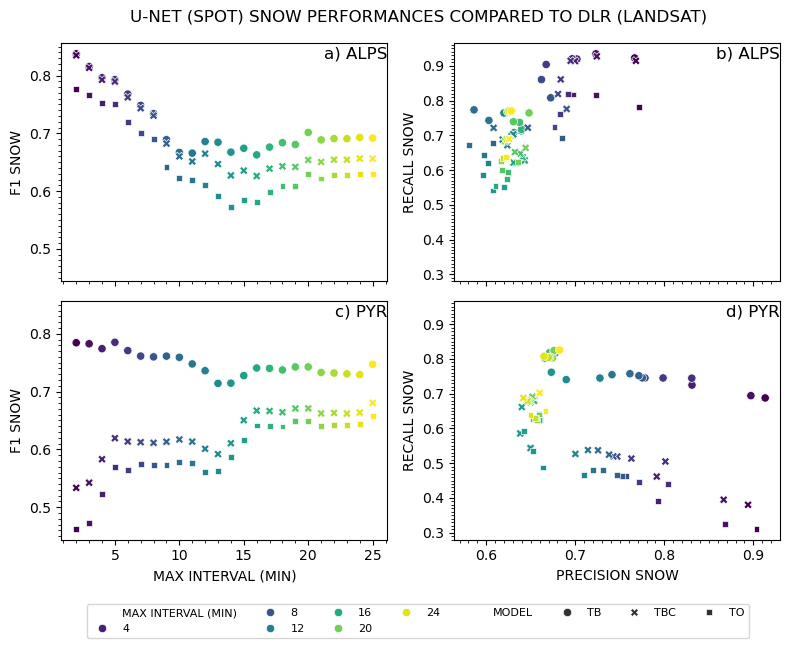

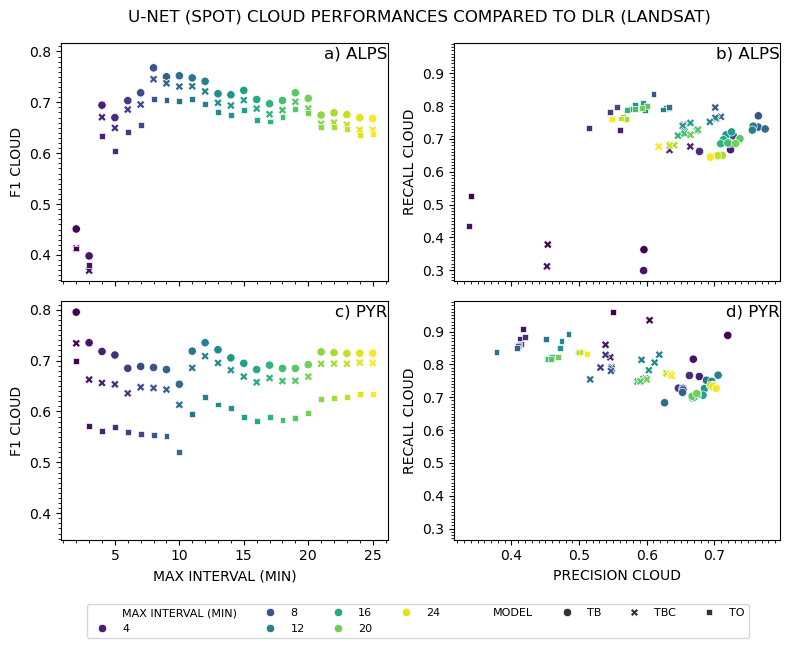

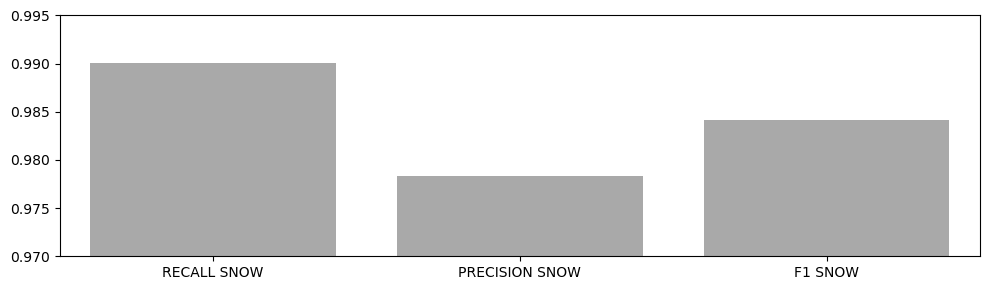

In [12]:
#study snow depth sensibility for each models
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/PAIRS"

def cm_3x3_metrics(g):


    try:
        kappa, OA, WOA, list_F1, list_Recalls, list_Precisions = getmetrics(g['GG'].sum(),g['GS'].sum(),g['GC'].sum(),
                                                                            g['SG'].sum(),g['SS'].sum(),g['SC'].sum(),
                                                                            g['CG'].sum(),g['CS'].sum(),g['CC'].sum())
        RECALL_GROUND = list_Recalls[0]
        PRECISION_GROUND = list_Precisions[0]
        F1_GROUND = list_F1[0]
        RECALL_SNOW = list_Recalls[1]
        PRECISION_SNOW = list_Precisions[1]
        F1_SNOW = list_F1[1]
        RECALL_CLOUD = list_Recalls[2]
        PRECISION_CLOUD = list_Precisions[2]
        F1_CLOUD = list_F1[2]
    except ZeroDivisionError:
        RECALL_GROUND = np.nan
        PRECISION_GROUND = np.nan
        F1_GROUND = np.nan
        RECALL_SNOW = np.nan
        PRECISION_SNOW = np.nan
        F1_SNOW = np.nan
        RECALL_CLOUD = np.nan
        PRECISION_CLOUD = np.nan
        F1_CLOUD = np.nan
        
    return pd.Series( {"RECALL GROUND":RECALL_GROUND,
        "PRECISION GROUND":PRECISION_GROUND,
        "F1 GROUND":F1_GROUND,
        "RECALL SNOW":RECALL_SNOW,
        "PRECISION SNOW":PRECISION_SNOW,
        "F1 SNOW":F1_SNOW,
        "RECALL CLOUD":RECALL_CLOUD,
        "PRECISION CLOUD":PRECISION_CLOUD,
        "F1 CLOUD":F1_CLOUD} )

def cm_2x2_metrics(g):
    RECALL_SNOW = g['SS'].sum()/float(g['SS'].sum() + g['SG'].sum())
    PRECISION_SNOW = g['SS'].sum()/float(g['SS'].sum() + g['GS'].sum())
    RECALL_GROUND = g['GG'].sum()/float(g['GG'].sum() + g['GS'].sum())
    PRECISION_GROUND = g['GG'].sum()/float(g['GG'].sum() + g['SG'].sum())
    F1_SNOW = 2*PRECISION_SNOW*RECALL_SNOW/(PRECISION_SNOW+RECALL_SNOW)
    F1_GROUND = 2*PRECISION_GROUND*RECALL_GROUND/(PRECISION_GROUND+RECALL_GROUND)

        
    return pd.Series( {"RECALL GROUND":RECALL_GROUND,
        "PRECISION GROUND":PRECISION_GROUND,
        "F1 GROUND":F1_GROUND,
        "RECALL SNOW":RECALL_SNOW,
        "PRECISION SNOW":PRECISION_SNOW,
        "F1 SNOW":F1_SNOW} )



df_3x3_1minb = df3.groupby(['MODEL','MTN','MAX INTERVAL (MIN)'], as_index=False).apply( cm_3x3_metrics )

df_2x2b = df2.groupby(['MODEL'], as_index=False).apply( cm_2x2_metrics )



df_3x3_1min = df_3x3_1minb.melt(id_vars=['MODEL','MTN','MAX INTERVAL (MIN)'], value_vars=['RECALL GROUND',
                                                                     'PRECISION GROUND',
                                                                     'F1 GROUND',
                                                                     'RECALL SNOW',
                                                                     'PRECISION SNOW',
                                                                     'F1 SNOW',
                                                                     'RECALL CLOUD',
                                                                     'PRECISION CLOUD', 
                                                                     'F1 CLOUD'],var_name='METRICS', value_name='VALUES')


df_2x2 = df_2x2b.melt(id_vars=['MODEL'], value_vars=['RECALL GROUND',
                                                    'PRECISION GROUND',
                                                    'F1 GROUND',
                                                    'RECALL SNOW',
                                                    'PRECISION SNOW',
                                                    'F1 SNOW'],var_name='METRICS', value_name='VALUES')






fig, axs = plt.subplots(2,2,sharex='col',sharey='col')
sn.scatterplot(ax=axs[0,0],data = df_3x3_1minb.query("MTN == 'ALP'"),x = 'MAX INTERVAL (MIN)',y='F1 SNOW',hue="MAX INTERVAL (MIN)",style="MODEL",palette="viridis")
sn.scatterplot(ax=axs[0,1],data = df_3x3_1minb.query("MTN == 'ALP'"),x = 'PRECISION SNOW',y='RECALL SNOW',hue="MAX INTERVAL (MIN)",style="MODEL",palette="viridis")
sn.scatterplot(ax=axs[1,0],data = df_3x3_1minb.query("MTN == 'PYR'"),x = 'MAX INTERVAL (MIN)',y='F1 SNOW',hue="MAX INTERVAL (MIN)",style="MODEL",palette="viridis")
sn.scatterplot(ax=axs[1,1],data = df_3x3_1minb.query("MTN == 'PYR'"),x = 'PRECISION SNOW',y='RECALL SNOW',hue="MAX INTERVAL (MIN)",style="MODEL",palette="viridis")
axs[0,0].get_legend().remove()
axs[0,0].set_title("a) ALPS", y=0.9,loc='right')
axs[0,1].get_legend().remove()
axs[0,1].set_title("b) ALPS", y=0.9,loc='right')
axs[1,0].get_legend().remove()
axs[1,0].set_title("c) PYR", y=0.9,loc='right')
axs[1,0].xaxis.set_minor_locator(MultipleLocator(1))
axs[1,0].yaxis.set_minor_locator(MultipleLocator(0.01))
axs[1,1].get_legend().remove()
axs[1,1].set_title("d) PYR", y=0.9,loc='right')
axs[1,1].xaxis.set_minor_locator(MultipleLocator(0.01))
axs[1,1].yaxis.set_minor_locator(MultipleLocator(0.01))
handles, labels = axs[1,1].get_legend_handles_labels()
lgd = fig.legend(handles, labels,bbox_to_anchor=(0.95,0),fontsize=8,ncol=8)
plt.suptitle("U-NET (SPOT) SNOW PERFORMANCES COMPARED TO DLR (LANDSAT)",x=0.53)
fig.set_figwidth(8)
fig.set_figheight(6)
fig.tight_layout()
plt.savefig(op.join(plot_path,f'1.png'),bbox_inches='tight',format="png")


fig, axs = plt.subplots(2,2,sharex='col',sharey='col')
sn.scatterplot(ax=axs[0,0],data = df_3x3_1minb.query("MTN == 'ALP'"),x = 'MAX INTERVAL (MIN)',y='F1 CLOUD',hue="MAX INTERVAL (MIN)",style="MODEL",palette="viridis")
sn.scatterplot(ax=axs[0,1],data = df_3x3_1minb.query("MTN == 'ALP'"),x = 'PRECISION CLOUD',y='RECALL CLOUD',hue="MAX INTERVAL (MIN)",style="MODEL",palette="viridis")
sn.scatterplot(ax=axs[1,0],data = df_3x3_1minb.query("MTN == 'PYR'"),x = 'MAX INTERVAL (MIN)',y='F1 CLOUD',hue="MAX INTERVAL (MIN)",style="MODEL",palette="viridis")
sn.scatterplot(ax=axs[1,1],data = df_3x3_1minb.query("MTN == 'PYR'"),x = 'PRECISION CLOUD',y='RECALL CLOUD',hue="MAX INTERVAL (MIN)",style="MODEL",palette="viridis")
axs[0,0].get_legend().remove()
axs[0,0].set_title("a) ALPS", y=0.9,loc='right')
axs[0,1].get_legend().remove()
axs[0,1].set_title("b) ALPS", y=0.9,loc='right')
axs[1,0].get_legend().remove()
axs[1,0].set_title("c) PYR", y=0.9,loc='right')
axs[1,0].xaxis.set_minor_locator(MultipleLocator(1))
axs[1,0].yaxis.set_minor_locator(MultipleLocator(0.01))
axs[1,1].get_legend().remove()
axs[1,1].set_title("d) PYR", y=0.9,loc='right')
axs[1,1].xaxis.set_minor_locator(MultipleLocator(0.01))
axs[1,1].yaxis.set_minor_locator(MultipleLocator(0.01))
handles, labels = axs[1,1].get_legend_handles_labels()
lgd = fig.legend(handles, labels,bbox_to_anchor=(0.95,0),fontsize=8,ncol=8)
plt.suptitle("U-NET (SPOT) CLOUD PERFORMANCES COMPARED TO DLR (LANDSAT)",x=0.53)
fig.set_figwidth(8)
fig.set_figheight(6)
fig.tight_layout()
plt.savefig(op.join(plot_path,f'2.png'),bbox_inches='tight',format="png")


print(df_2x2.query(" METRICS.str.contains('SNOW') & MODEL == 'TB'",engine="python"))
fig, axs = plt.subplots()
sn.barplot(ax=axs,data = df_2x2.query(" METRICS.str.contains('SNOW') & MODEL == 'TB'",engine="python"),x = 'METRICS',y='VALUES',color="darkgrey")
#axs.get_legend().remove()
axs.set_ylim([0.97, 0.995])
#plt.legend(ncol=4)
axs.set_xlabel('')
axs.set_ylabel('')
fig.set_figwidth(10)
fig.set_figheight(3)
fig.tight_layout()
plt.savefig(op.join(plot_path,f'3.pdf'),format="pdf",transparent=False,facecolor='white')



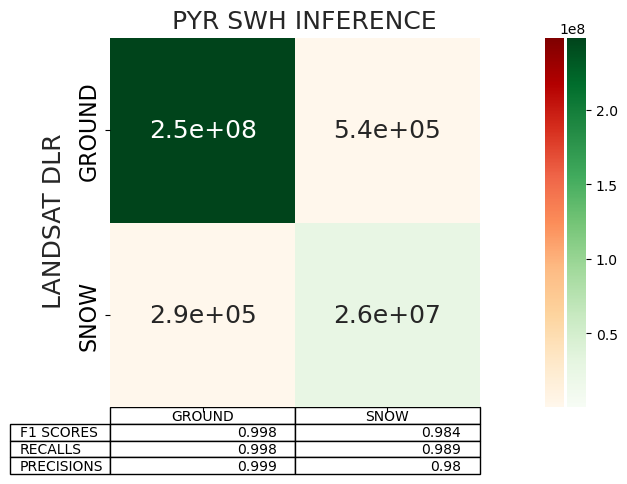

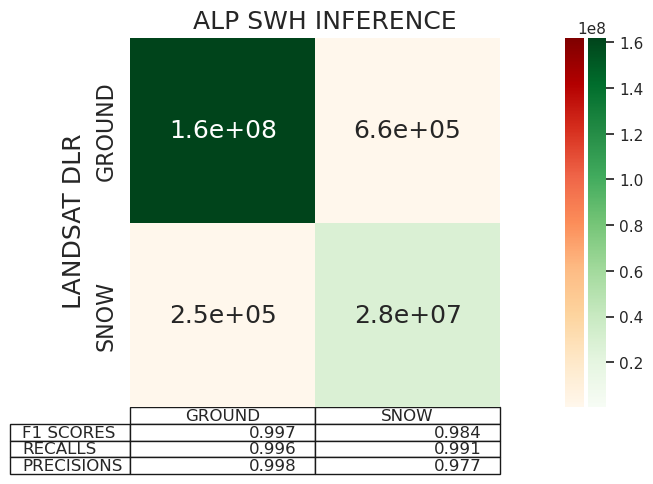

In [37]:
for mtn in ["PYR",'ALP']:
    
    df_cm = df2.query(f"MTN == '{mtn}' ").groupby(['MODEL'], as_index=False)['GG','GS','SS','SG'].sum()

    GG = (df_cm.query("MODEL == 'TB'")).iloc[0]['GG']
    GS = (df_cm.query("MODEL == 'TB'")).iloc[0]['GS']
    SS = (df_cm.query("MODEL == 'TB'")).iloc[0]['SS']
    SG = (df_cm.query("MODEL == 'TB'")).iloc[0]['SG']
    RECALL_SNOW = SS/float(SS + SG)
    PRECISION_SNOW = SS/float(SS + GS)
    RECALL_GROUND = GG/float(GG + GS)
    PRECISION_GROUND = GG/float(GG + SG)
    F1_SNOW = 2*PRECISION_SNOW*RECALL_SNOW/(PRECISION_SNOW+RECALL_SNOW)
    F1_GROUND = 2*PRECISION_GROUND*RECALL_GROUND/(PRECISION_GROUND+RECALL_GROUND)
    list_type = ["F1 SCORES","RECALLS","PRECISIONS"]
    array_metrics = np.stack((np.array([F1_GROUND,F1_SNOW]), np.array([RECALL_GROUND,RECALL_SNOW]),np.array([PRECISION_GROUND,PRECISION_SNOW])),axis=0)
    classes=["GROUND","SNOW"]
    cm_total = np.array([[GG,GS],[SG,SS]]) 
    df_cm_plt = pd.DataFrame(cm_total, index = classes,columns = classes)
    fig = plt.figure()
    gs0 = pltg.GridSpec(1,2, width_ratios=[20,2], hspace=0.05)
    gs00 = pltg.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[1], hspace=0)
    vmin = np.min(cm_total)
    vmax = np.max(cm_total)
    off_diag_mask = np.eye(*cm_total.shape, dtype=bool)
    ax = fig.add_subplot(gs0[0])
    cax1 = fig.add_subplot(gs00[0])
    cax2 = fig.add_subplot(gs00[1])
    #ax2 = fig.add_subplot(gs0[1,:])


    ax.set_xlabel( "Predicted labels" )
    ax.set_ylabel( "True labels" )
    #ax.xaxis.set_label_position('top') 


    sn.heatmap(df_cm_plt, annot=True, mask=~off_diag_mask, cmap='Greens', vmin=vmin, vmax=vmax, ax=ax, cbar_ax=cax2,annot_kws=dict(size = 18),square=True)
    sn.heatmap(df_cm_plt, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, ax=ax, cbar_ax=cax1, cbar_kws=dict(ticks=[]),annot_kws=dict(size = 18),square=True)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 16)

    ax.table(cellText=numpy.round(array_metrics,3), rowLabels=list_type, colLabels=classes,loc='bottom')
    ax.xaxis.set_ticklabels([])


    sn.set(font_scale=1)

    fig.text(0.05,0.5,  'LANDSAT DLR',rotation = 90, va='center',size=18)
    fig.text(0.46,0.9,  f'{mtn} SWH INFERENCE', ha='center',size=18)
    #fig.text(0.1,0.01,'KAPPA : {:.3f} OA : {:.3f} WOA : {:.3f}'.format(kappa, OA,WOA),size=16)

    #matplotlib.rcParams.update({'font.size': 15})
    #plt.suptitle( f'{model_name} CONFUSION MATRIX', size = 20)
    #plt.savefig(analysis_path+'/all_cm.png', facecolor='white', transparent=False)

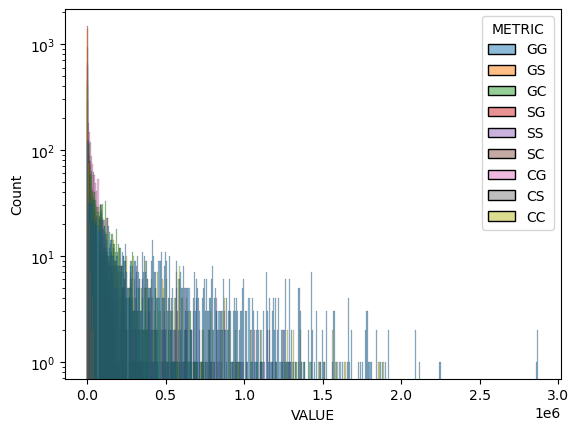

In [189]:
sn.histplot(data=df.query("TYPE == 'COUNT'"),x="VALUE",hue="METRIC")
plt.yscale('log')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'GC'),
  Text(1, 0, 'SC'),
  Text(2, 0, 'CG'),
  Text(3, 0, 'CS'),
  Text(4, 0, 'CC')])

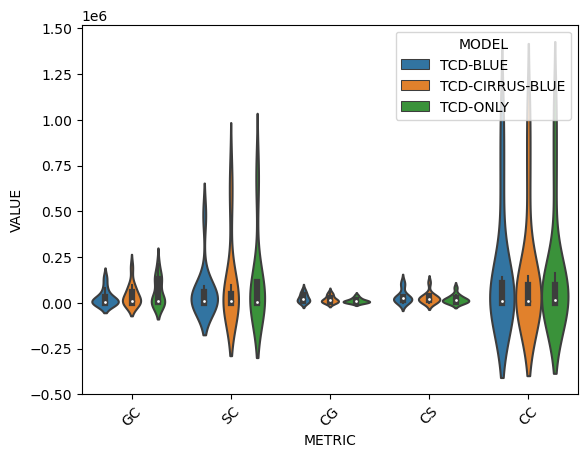

In [26]:
fig, axs = plt.subplots()
sn.boxplot(data=df.query("TYPE == 'COUNT' & (METRIC == 'CC' | METRIC == 'GC' | METRIC == 'CG' | METRIC == 'SC' | METRIC == 'CS') & ΔTIME <= 120"), x="METRIC", y="VALUE", hue="MODEL",showfliers = False)

plt.xticks(rotation=45)

(array([0, 1, 2]),
 [Text(0, 0, 'F1_CLOUD'),
  Text(1, 0, 'RECALL_CLOUD'),
  Text(2, 0, 'PRECISION_CLOUD')])

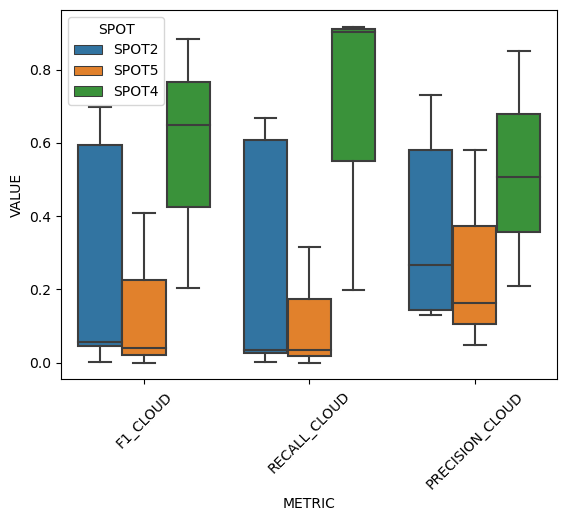

In [48]:
fig, axs = plt.subplots()
sn.boxplot(data=df.query("MODEL == 'TCD-BLUE' &(METRIC == 'F1_CLOUD' | METRIC == 'PRECISION_CLOUD' | METRIC == 'RECALL_CLOUD' )& ΔTIME <= 120"), x="METRIC", y="VALUE", hue="SPOT")

plt.xticks(rotation=45)

<Axes: xlabel='COUNT_CLOUD', ylabel='PRECISION_CLOUD'>

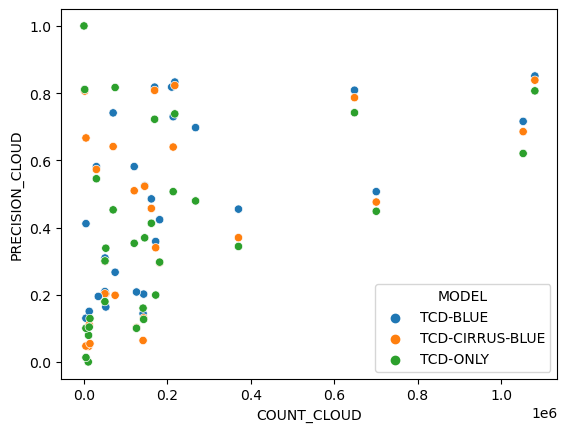

In [130]:
sn.scatterplot(data=df2.query("ΔTIME <= 300"), x="COUNT_CLOUD", y="PRECISION_CLOUD",hue="MODEL")

<Axes: xlabel='ΔTIME', ylabel='SC'>

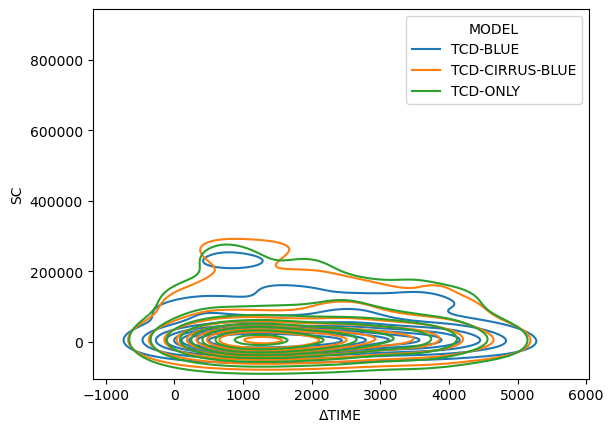

In [153]:
sn.kdeplot(data=df2, x="ΔTIME", y="SC",hue="MODEL")